# Exercise 1: Optimize lepton selection

* First, print the distributions of the relevant variables for *all* the Monte Carlo samples (i.e. all the *channels* of the $Z$-boson decay to be studied). Which variables are these? Give sensible ranges to include all the events in the samples (both MC and OPAL data) 
* Do the same for **one** of the OPAL data samples (your lab assistant will decide which one you choose).
* Describe the results.
* Optimize the object selection by applying cuts. Make a strategy on how to proceed to find the optimal selection. which information do you need? in thin the
* Determine the efficiency and the amount of background for each $Z$ decay channel. Use the simulated events $e^+e^-$, $\mu^+\mu^-$, $\tau^+\tau^-$ and hadrons ($qq$). Represent the result in a matrix form and think carefully about how you have to correct the measured rates. Don't forget to calculate the errors!
* How do we estimate the statistical fluctuations per bin?

### Download missing libraries
Comment in the following two lines in case some of the libraries cannot be imported. Please restart the kernel after download+upgrade has successfully finished

In [1]:
'''
### Download libraries
%pip install uproot
%pip install awkward
%pip install mplhep
%pip install numpy
%pip install matplotlib
%pip install scipy
%pip install tensorflow
%pip install sklearn
### Upgrade libraries to latest version
%pip install uproot awkward mplhep numpy matplotlib scipy --upgrade
'''

'\n### Download libraries\n%pip install uproot\n%pip install awkward\n%pip install mplhep\n%pip install numpy\n%pip install matplotlib\n%pip install scipy\n%pip install tensorflow\n%pip install sklearn\n### Upgrade libraries to latest version\n%pip install uproot awkward mplhep numpy matplotlib scipy --upgrade\n'

### Import libraries

In [2]:
import uproot
import awkward as ak
import mplhep
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
import json
import sympy as sy

## *Example*: Reading a ROOT.TTree and plotting a variable with a cut
We will open data and Monte Carlo samples using **uproot**. Uproot is a reader and a writer of the ROOT file format using only Python and Numpy. Unlike PyROOT and root_numpy, uproot does not depend on C++ ROOT so that no local compilation of the ROOT libraries is needed to access the data.

You can find more info on uproot following the references:
* Github repo: https://github.com/scikit-hep/uproot4
* Tutorial: https://masonproffitt.github.io/uproot-tutorial/
* Video tutorial on uproot and awkward arrays:  https://www.youtube.com/embed/ea-zYLQBS4U 

First, let's specify the folder path for both data and Monte Carlo (MC) samples

In [3]:
## Take folder with samples from Google Drive
#%pip install google-colab
#from google.colab import drive
#import os
#samplefolder = drive.mount('samples')
#path_data = 'samples/data/'
path_mc = './opal_data/mc/'

### Open the file introducing file path
file_ee = uproot.open(path_mc+'ee.root')
file_mm = uproot.open(path_mc+'mm.root')
file_tt = uproot.open(path_mc+'tt.root')
file_qq = uproot.open(path_mc+'qq.root')

ttree_name = 'myTTree'

## Load branches
mc_ee = file_ee[ttree_name].arrays()
mc_mm = file_mm[ttree_name].arrays()
mc_tt = file_tt[ttree_name].arrays()
mc_qq = file_qq[ttree_name].arrays()

mc_ee = ak.to_numpy(mc_ee)
mc_mm = ak.to_numpy(mc_mm)
mc_tt = ak.to_numpy(mc_tt)
mc_qq = ak.to_numpy(mc_qq)

mc_ee = np.array([np.array(mc_ee[i].tolist(),dtype=np.float32) for i in range(len(mc_ee))])
mc_mm = np.array([np.array(mc_mm[i].tolist(),dtype=np.float32) for i in range(len(mc_mm))])
mc_tt = np.array([np.array(mc_tt[i].tolist(),dtype=np.float32) for i in range(len(mc_tt))])
mc_qq = np.array([np.array(mc_qq[i].tolist(),dtype=np.float32) for i in range(len(mc_qq))])

# Create the Full array and the Labels to identify every event
#0->ee ; 1->mm ; 2->tt ; 3->hh
mc_all = np.concatenate((mc_ee,mc_mm,mc_tt,mc_qq))
ML_Labels = np.concatenate((   np.array([0]*len(mc_ee)), np.array([1]*len(mc_mm)), np.array([2]*len(mc_tt)), np.array([3]*len(mc_qq))  ))
ML_Labels_Cat = keras.utils.to_categorical(ML_Labels , num_classes=4)

# making some dictionaries and constants to ease the data handling
Types = {0:[mc_ee,"Electrons","g"], 1:[mc_mm,"Muons","b"], 2:[mc_tt,"Taus","c"], 3:[mc_qq,"Quarks","r"], 4:[mc_all,"All",'k']}
Nametable = {'Run':0, 'Event':1, 'Ncharged':2, 'Pcharged':3, 'E_ecal':4, 'E_hcal':5, 'E_lep':6, 'Cos_thru':7, 'Cos_thet':8 }
Outfolder ="./MPL_Model/"

The last line shows all the variables available in the TTree to carry out the experiment. The meaning of these is described in the following table

| Variable name | Description |
| --- | --- | 
| <pre>run</pre> | Run number |
| <pre>event</pre> | Event number |
| <pre>Ncharged</pre> | Number of charged tracks |
| <pre>Pcharged</pre> | Total scalar sum of track momenta |
| <pre>E_ecal</pre> | Total energy measured in the electromagnetic calorimeter |
| <pre>E_hcal</pre> | Total energy measured in the hadronic calorimete |
| <pre>E_lep</pre> | LEP beam energy (=$\sqrt{s}/2$) |
| <pre>cos_thru</pre> | cosine of the polar angle between beam axis and thrust axis |
| <pre>cos_thet</pre> | cosine of the polar angle between incoming positron and outgoing positive particle |

We proceed to plot *PCharged* for illustration.

### Make a plot with a certain selection

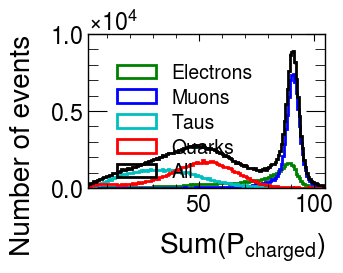

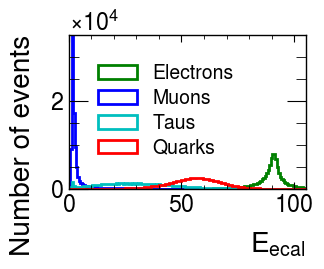

In [4]:
def plotting(variable, xmin, xmax, ymin, ymax, xlabel="X Var", ylabel="Y Var" ,plotall=True):
    "Function to Plot any variable on the .root from just one line"
    plt.figure(figsize=(3,2))
    binning = round(np.sqrt(len(Types[0][0][:,variable])))
    rang = 4
    if plotall: rang=5
    for i in range(rang):
        bin_content, bin_edges, _ = plt.hist(Types[i][0][:,variable],bins=binning,range=(0.,200.), histtype='step',  linewidth=2, edgecolor=Types[i][2], label=Types[i][1],    density=False)
    mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars
    error_sizes = np.sqrt(bin_content)
    plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none')

    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc=2)
    plt.show()


plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 

plotting(Nametable["Pcharged"],2.,105.,0.,10000,'$Sum(P_{charged})$', 'Number of events', plotall=True)
plotting(Nametable["E_ecal"],0.,105.,0.,35000,'$E_{ecal}$', 'Number of events', plotall=False)

# DNN Multi-Class Classification Model Training
*we only needed to run this code one time to generate and train the network

## Model Application

In [5]:
# Here we load and apply the already trained model
Model = keras.models.load_model(Outfolder)
Response = Model.predict(mc_all, verbose=0)

## Ploting the DNN Results and calculating the efficiency

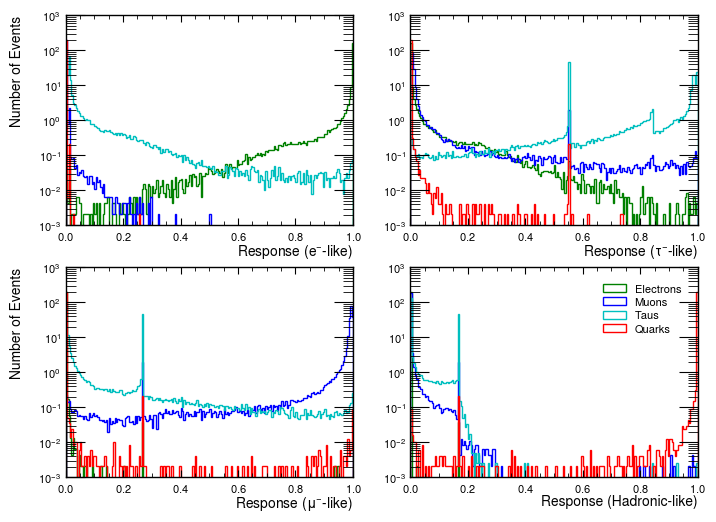

In [6]:
# In very loose words:
# From the mc data we trained the model to output the % of certainty of a given event to be part of the ee, mm, tt and hh categories
# For example, an event can have the following result (0.2, 0.8, 0.85, 0.1), meaning that it is likely an mm or a tt event
# after applying the model we have to choose the order and value on wich we cut to separate their contributions 

# We plot the model results (Responses)
fig, axs = plt.subplots(2, 2)
for i in range(4):
    axs[0, 0].hist(Response[ML_Labels==i][:,0],bins=200,range=(0,1), linewidth=1, density=True,color=Types[i][2], label=Types[i][1], histtype='step')
    axs[0, 0].set_yscale('log')
    axs[0, 0].tick_params(labelsize=8)
    axs[0, 0].set_xlabel(r"Response ($e^{-}$-like)", fontsize=10)
    axs[0, 0].set_ylabel("Number of Events", fontsize=10)
    axs[0, 0].xaxis.set_label_coords(1.0, -0.08)


    axs[1, 0].hist(Response[ML_Labels==i][:,1],bins=200,range=(0,1), linewidth=1, density=True,color=Types[i][2], label=Types[i][1], histtype='step')
    axs[1, 0].set_yscale('log')
    axs[1, 0].tick_params(labelsize=8)
    axs[1, 0].set_xlabel(r"Response ($\mu^{-}$-like)", fontsize=10)
    axs[1, 0].set_ylabel("Number of Events", fontsize=10)
    axs[1, 0].xaxis.set_label_coords(1.0, -0.08)

    axs[0, 1].hist(Response[ML_Labels==i][:,2],bins=200,range=(0,1), linewidth=1, density=True,color=Types[i][2], label=Types[i][1], histtype='step')
    axs[0, 1].set_yscale('log')
    axs[0, 1].tick_params(labelsize=8)
    axs[0, 1].set_xlabel(r"Response ($\tau^{-}$-like)", fontsize=10)
    axs[0, 1].xaxis.set_label_coords(1.0, -0.08)

    axs[1, 1].hist(Response[ML_Labels==i][:,3],bins=200,range=(0,1), linewidth=1, density=True,color=Types[i][2], label=Types[i][1], histtype='step')
    axs[1, 1].set_yscale('log')
    axs[1, 1].tick_params(labelsize=8)
    axs[1, 1].set_xlabel(r"Response (Hadronic-like)", fontsize=10)
    axs[1, 1].xaxis.set_label_coords(1.0, -0.08)

plt.legend(prop={'size': 8})
#fig.tight_layout()
plt.show()

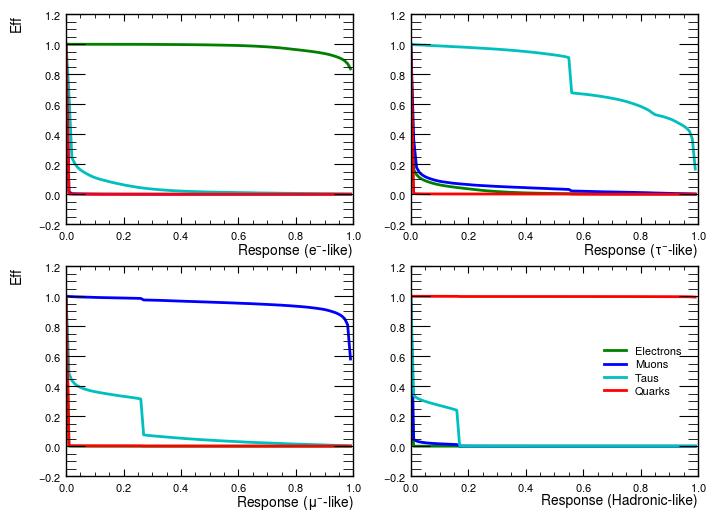

Hadron Cut (N. Events):
 True Possitive=98354 ; False Possitive=17 ; False Negative=209
purity=0.9998271549708196
lost Events=0.0021249771234520204


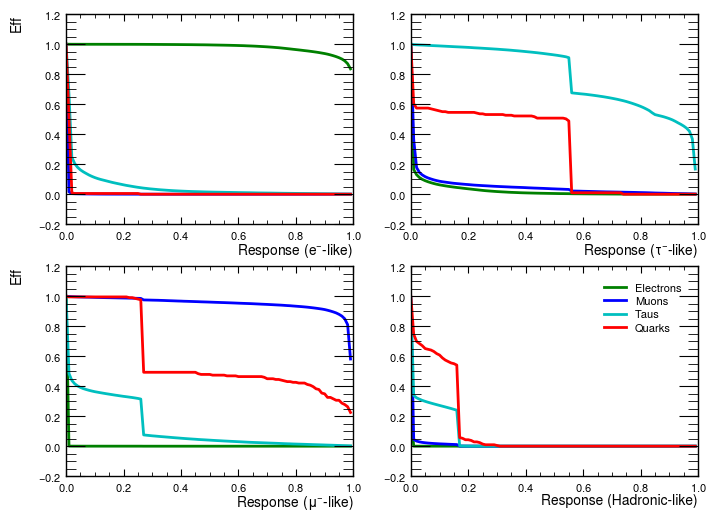

In [7]:
# Now we need to determine the cut values and the order on which we are going to cut
def efficiencycalc(responses,labels,Responsetype):         #0->ee ; 1->mm ; 2->tt ; 3->hh
    SavedEff = {"Electrons":np.array([]),"Muons":np.array([]),"Taus":np.array([]),"Quarks":np.array([]),"FalsePossitives":np.array([])}
    Current_ee = responses[labels==0][:,Responsetype]
    initial_ee = len(Current_ee)

    Current_mm = responses[labels==1][:,Responsetype]
    initial_mm = len(Current_mm)

    Current_tt = responses[labels==2][:,Responsetype]
    initial_tt = len(Current_tt)

    Current_hh = responses[labels==3][:,Responsetype]
    initial_hh = len(Current_hh)
    for i in rangeX:
        Current_ee = Current_ee[Current_ee>i]
        Current_mm = Current_mm[Current_mm>i]
        Current_tt = Current_tt[Current_tt>i]
        Current_hh = Current_hh[Current_hh>i]
        SavedEff["Electrons"] = np.append(SavedEff["Electrons"], len(Current_ee)/initial_ee)
        SavedEff["Muons"] = np.append(SavedEff["Muons"], len(Current_mm)/initial_mm)
        SavedEff["Taus"] = np.append(SavedEff["Taus"], len(Current_tt)/initial_tt)
        SavedEff["Quarks"] = np.append(SavedEff["Quarks"], len(Current_hh)/initial_hh)
        if Responsetype==0:
            SavedEff["FalsePossitives"] = np.append(SavedEff["FalsePossitives"], (len(Current_mm)+len(Current_tt)+len(Current_hh))/(initial_mm+initial_tt+initial_hh) )
        if Responsetype==1:
            SavedEff["FalsePossitives"] = np.append(SavedEff["FalsePossitives"], (len(Current_ee)+len(Current_tt)+len(Current_hh))/(initial_ee+initial_tt+initial_hh) )
        if Responsetype==2:
            SavedEff["FalsePossitives"] = np.append(SavedEff["FalsePossitives"], (len(Current_ee)+len(Current_mm)+len(Current_hh))/(initial_ee+initial_mm+initial_hh) )
        if Responsetype==3:
            SavedEff["FalsePossitives"] = np.append(SavedEff["FalsePossitives"], (len(Current_ee)+len(Current_mm)+len(Current_tt))/(initial_ee+initial_mm+initial_tt) )


    return SavedEff

def plotall(array1, array2, array3, array4):
    fig2, axs2 = plt.subplots(2, 2)
    for i in range(4):
        axs2[0, 0].plot(rangeX, array1[Types[i][1]], color=Types[i][2], label=Types[i][1])
        axs2[0, 0].tick_params(labelsize=8)
        axs2[0, 0].set_xlabel(r"Response ($e^{-}$-like)", fontsize=10)
        axs2[0, 0].set_ylabel("Eff", fontsize=10)
        axs2[0, 0].xaxis.set_label_coords(1.0, -0.08)

        axs2[1, 0].plot(rangeX, array2[Types[i][1]], color=Types[i][2], label=Types[i][1])
        axs2[1, 0].tick_params(labelsize=8)
        axs2[1, 0].set_xlabel(r"Response ($\mu^{-}$-like)", fontsize=10)
        axs2[1, 0].set_ylabel("Eff", fontsize=10)
        axs2[1, 0].xaxis.set_label_coords(1.0, -0.08)

        axs2[0, 1].plot(rangeX, array3[Types[i][1]], color=Types[i][2], label=Types[i][1])
        axs2[0, 1].tick_params(labelsize=8)
        axs2[0, 1].set_xlabel(r"Response ($\tau^{-}$-like)", fontsize=10)
        axs2[0, 1].xaxis.set_label_coords(1.0, -0.08)

        axs2[1, 1].plot(rangeX, array4[Types[i][1]], color=Types[i][2], label=Types[i][1])
        axs2[1, 1].tick_params(labelsize=8)
        axs2[1, 1].set_xlabel(r"Response (Hadronic-like)", fontsize=10)
        axs2[1, 1].xaxis.set_label_coords(1.0, -0.08)

    plt.legend(prop={'size': 8})
    plt.show()

rangeX = np.arange(0.0,1.0,0.01)
ee_eff = efficiencycalc(Response,ML_Labels,0)
mm_eff = efficiencycalc(Response,ML_Labels,1)
tt_eff = efficiencycalc(Response,ML_Labels,2)
hh_eff = efficiencycalc(Response,ML_Labels,3)

plotall(ee_eff,mm_eff,tt_eff,hh_eff)

# the Hadron cut is clearly the easiest one to do, thus its better to do first (this way, events that would be categorized as hh will not be present at all in the other cuts)

'''To Look for Hadron Cut'''  # here I'm just ploting the true possitives/false positives to choose the cut value (the plot is not really interesting so I let it commented)
#for i in range(len(rangeX)):
#    print([round(rangeX[i],3), round(hh_eff[Types[3][1]][i],5), round(hh_eff["FalsePossitives"][i],5)]) # round(hh_eff[Types[3][1]][i]/hh_eff["FalsePossitives"][i],5)
#plt.plot(rangeX,hh_eff[Types[3][1]]/hh_eff["FalsePossitives"])
#plt.axvline(0.32, ls="--", color="k")
#plt.show()

condition_hh = Response[:,3]>=0.32
print("Hadron Cut (N. Events):\n True Possitive={} ; False Possitive={} ; False Negative={}".format(len(ML_Labels[condition_hh][ML_Labels[condition_hh]==3]), len(ML_Labels[condition_hh][ML_Labels[condition_hh]!=3]), len(ML_Labels[np.invert(condition_hh)][ML_Labels[np.invert(condition_hh)]==3])))
print("purity={}".format(1-(len(ML_Labels[condition_hh][ML_Labels[condition_hh]!=3])/len(ML_Labels[condition_hh][ML_Labels[condition_hh]==3]))))
print("lost Events={}".format(len(ML_Labels[np.invert(condition_hh)][ML_Labels[np.invert(condition_hh)]==3])/len(ML_Labels[condition_hh][ML_Labels[condition_hh]==3])))


'''After Hadron Cut'''
#0->ee ; 1->mm ; 2->tt ; 3->hh
ee_eff_1 = efficiencycalc(Response[np.invert(condition_hh)],ML_Labels[np.invert(condition_hh)],0)
mm_eff_1 = efficiencycalc(Response[np.invert(condition_hh)],ML_Labels[np.invert(condition_hh)],1)
tt_eff_1 = efficiencycalc(Response[np.invert(condition_hh)],ML_Labels[np.invert(condition_hh)],2)
hh_eff_1 = efficiencycalc(Response[np.invert(condition_hh)],ML_Labels[np.invert(condition_hh)],3)
plotall(ee_eff_1,mm_eff_1,tt_eff_1,hh_eff_1)

Electron Cut (N. Events):
 True Possitive=93194 ; False Possitive=1007 ; False Negative=608
purity=0.9891945833422753
lost Events=0.006524025151833809


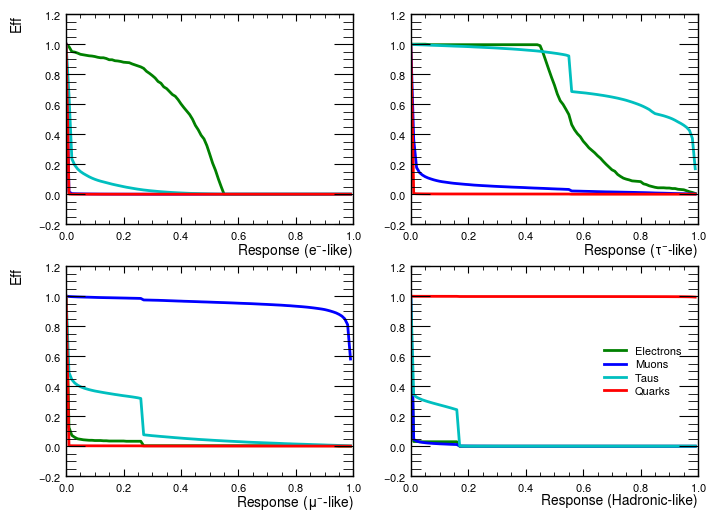

In [8]:
'''To Look for Electron Cut'''
#for i in range(len(rangeX)):
#    print([round(rangeX[i],3), round(ee_eff_1[Types[0][1]][i],5), round(ee_eff_1["FalsePossitives"][i],5)])
#plt.plot(rangeX,ee_eff_1[Types[0][1]]/ee_eff_1["FalsePossitives"])
#plt.axvline(0.35, ls="--", color="k")
#plt.show()

condition_ee = np.bitwise_and(np.invert(condition_hh), Response[:,0]>=0.55)
print("Electron Cut (N. Events):\n True Possitive={} ; False Possitive={} ; False Negative={}".format(len(ML_Labels[condition_ee][ML_Labels[condition_ee]==0]), len(ML_Labels[condition_ee][ML_Labels[condition_ee]!=0]), len(ML_Labels[np.invert(condition_ee)][ML_Labels[np.invert(condition_ee)]==0])))
print("purity={}".format(1-(len(ML_Labels[condition_ee][ML_Labels[condition_ee]!=0])/len(ML_Labels[condition_ee][ML_Labels[condition_ee]==0]))))
print("lost Events={}".format(len(ML_Labels[np.invert(condition_ee)][ML_Labels[np.invert(condition_ee)]==0])/len(ML_Labels[condition_ee][ML_Labels[condition_ee]==0])))

'''After Electron Cut'''
#0->ee ; 1->mm ; 2->tt ; 3->hh
ee_eff_2 = efficiencycalc(Response[np.invert(condition_ee)],ML_Labels[np.invert(condition_ee)],0)
mm_eff_2 = efficiencycalc(Response[np.invert(condition_ee)],ML_Labels[np.invert(condition_ee)],1)
tt_eff_2 = efficiencycalc(Response[np.invert(condition_ee)],ML_Labels[np.invert(condition_ee)],2)
hh_eff_2 = efficiencycalc(Response[np.invert(condition_ee)],ML_Labels[np.invert(condition_ee)],3)
plotall(ee_eff_2,mm_eff_2,tt_eff_2,hh_eff_2)


Tau Cut (N. Events):
 True Possitive=73932 ; False Possitive=4123 ; False Negative=5282
purity=0.9442325380078992
lost Events=0.07144402964886652


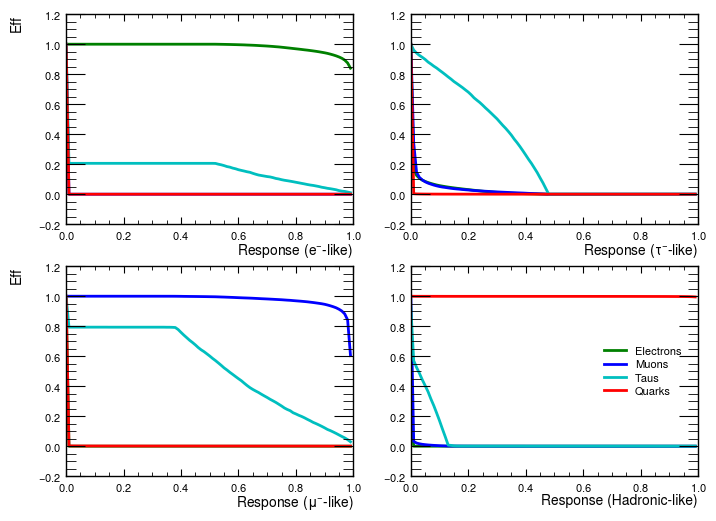

In [9]:
'''To Look for Tau Cut'''
#for i in range(len(rangeX)):
#    print([round(rangeX[i],3), round(tt_eff_3[Types[2][1]][i],5), round(tt_eff_3["FalsePossitives"][i],5)])
#plt.plot(rangeX,tt_eff_3[Types[2][1]]/tt_eff_3["FalsePossitives"])
#plt.axvline(0.56, ls="--", color="k")
#plt.show()


condition_tt = np.bitwise_and(np.invert(condition_ee), Response[:,2]>=0.48)
print("Tau Cut (N. Events):\n True Possitive={} ; False Possitive={} ; False Negative={}".format(len(ML_Labels[condition_tt][ML_Labels[condition_tt]==2]), len(ML_Labels[condition_tt][ML_Labels[condition_tt]!=2]), len(ML_Labels[np.invert(condition_tt)][ML_Labels[np.invert(condition_tt)]==2])))
print("purity={}".format(1-(len(ML_Labels[condition_tt][ML_Labels[condition_tt]!=2])/len(ML_Labels[condition_tt][ML_Labels[condition_tt]==2]))))
print("lost Events={}".format(len(ML_Labels[np.invert(condition_tt)][ML_Labels[np.invert(condition_tt)]==2])/len(ML_Labels[condition_tt][ML_Labels[condition_tt]==2])))

'''After Tau Cut'''
#0->ee ; 1->mm ; 2->tt ; 3->hh
ee_eff_4 = efficiencycalc(Response[np.invert(condition_tt)],ML_Labels[np.invert(condition_tt)],0)
mm_eff_4 = efficiencycalc(Response[np.invert(condition_tt)],ML_Labels[np.invert(condition_tt)],1)
tt_eff_4 = efficiencycalc(Response[np.invert(condition_tt)],ML_Labels[np.invert(condition_tt)],2)
hh_eff_4 = efficiencycalc(Response[np.invert(condition_tt)],ML_Labels[np.invert(condition_tt)],3)
plotall(ee_eff_4,mm_eff_4,tt_eff_4,hh_eff_4)




In [10]:
'''To Look for Muons Cut'''
#for i in range(len(rangeX)):
#    print([round(rangeX[i],3), round(mm_eff_2[Types[1][1]][i],5), round(mm_eff_2["FalsePossitives"][i],5)])
#plt.plot(rangeX,mm_eff_2[Types[0][1]]/mm_eff_2["FalsePossitives"])
#plt.axvline(0.7, ls="--", color="k")
#plt.show()


condition_mm = np.bitwise_and(np.invert(condition_tt), Response[:,1]>=0.6)
print("Muon Cut (N. Events):\n True Possitive={} ; False Possitive={} ; False Negative={}".format(len(ML_Labels[condition_mm][ML_Labels[condition_mm]==1]), len(ML_Labels[condition_mm][ML_Labels[condition_mm]!=1]), len(ML_Labels[np.invert(condition_mm)][ML_Labels[np.invert(condition_mm)]==1])))
print("purity={}".format(1-(len(ML_Labels[condition_mm][ML_Labels[condition_mm]!=1])/len(ML_Labels[condition_mm][ML_Labels[condition_mm]==1]))))
print("lost Events={}".format(len(ML_Labels[np.invert(condition_mm)][ML_Labels[np.invert(condition_mm)]==1])/len(ML_Labels[condition_mm][ML_Labels[condition_mm]==1])))

'''After Muon Cut'''
#0->ee ; 1->mm ; 2->tt ; 3->hh
ee_eff_3 = efficiencycalc(Response[np.invert(condition_mm)],ML_Labels[np.invert(condition_mm)],0)
mm_eff_3 = efficiencycalc(Response[np.invert(condition_mm)],ML_Labels[np.invert(condition_mm)],1)
tt_eff_3 = efficiencycalc(Response[np.invert(condition_mm)],ML_Labels[np.invert(condition_mm)],2)
hh_eff_3 = efficiencycalc(Response[np.invert(condition_mm)],ML_Labels[np.invert(condition_mm)],3)
#plotall(ee_eff_3,mm_eff_3,tt_eff_3,hh_eff_3)


Muon Cut (N. Events):
 True Possitive=89980 ; False Possitive=2481 ; False Negative=4401
purity=0.9724272060457879
lost Events=0.04891086908201823


In [11]:
from IPython.display import display, Math, Latex
effcy_matrix = np.zeros((4,4))
bkg_matrix = np.zeros((4,4))
error_matrix = np.zeros((4,4))
conditions = [condition_ee,condition_mm,condition_tt,condition_hh]
for i in range (4):
    for j in range(4):
        part_mask = ML_Labels==j
        val = len(ML_Labels[conditions[i]][part_mask[conditions[i]]])/len(ML_Labels[part_mask])
        val2 = 1-len(ML_Labels[conditions[i]][part_mask[conditions[i]]])/len(ML_Labels[conditions[i]])
#         val3 = np.sqrt(len(ML_Labels[conditions[i]]))
        effcy_matrix[i][j] = val
        bkg_matrix[i][j] = val2
#         error_matrix[i][j] = val3

aux_effM = sy.Matrix(np.round(effcy_matrix,4))
aux_bkgM = sy.Matrix(np.round(bkg_matrix,4))
aux_errM = sy.Matrix(np.round(error_matrix,4))
display(Math("\\textrm{Efficiency} =" + sy.latex(aux_effM)))
display(Math("\\textrm{Background} =" + sy.latex(aux_bkgM)))
# display(Math("\\textrm{Uncertainty(Stat)} =" + sy.latex(aux_errM)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

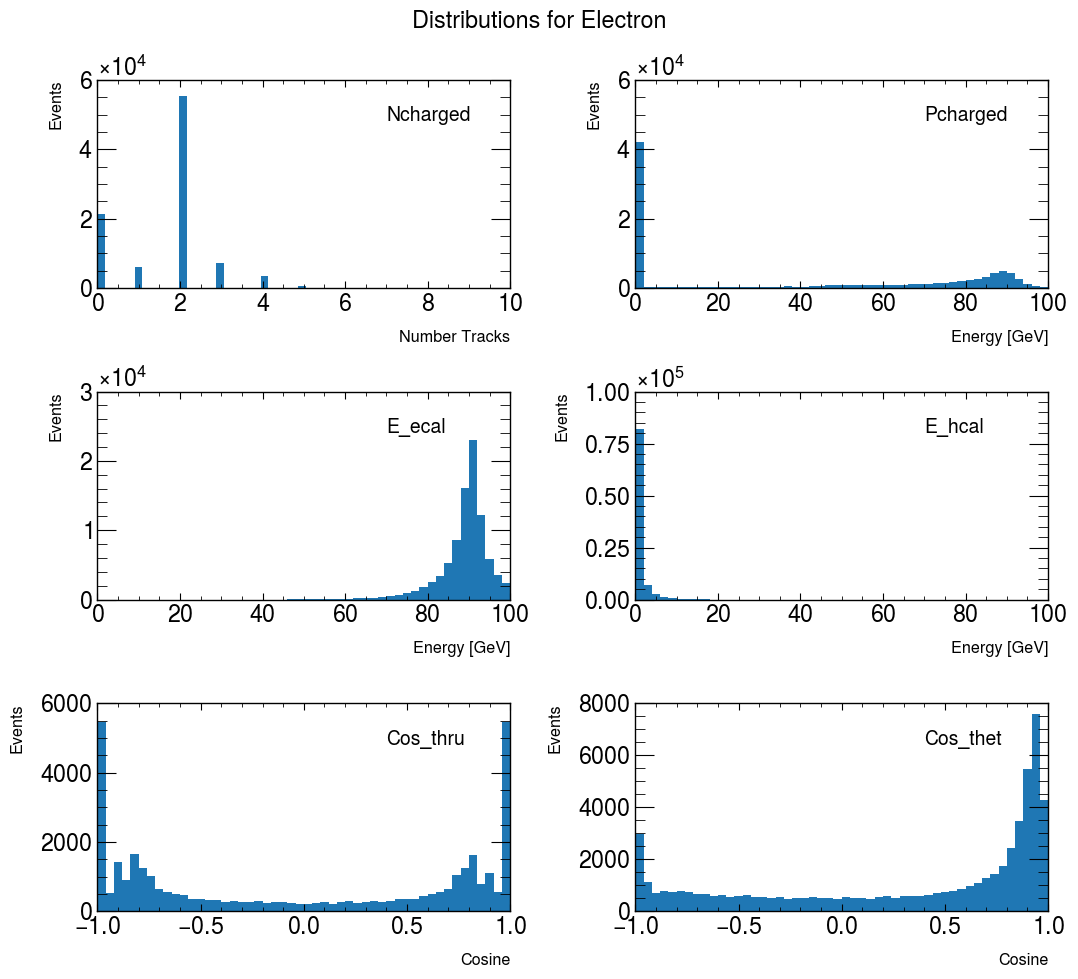

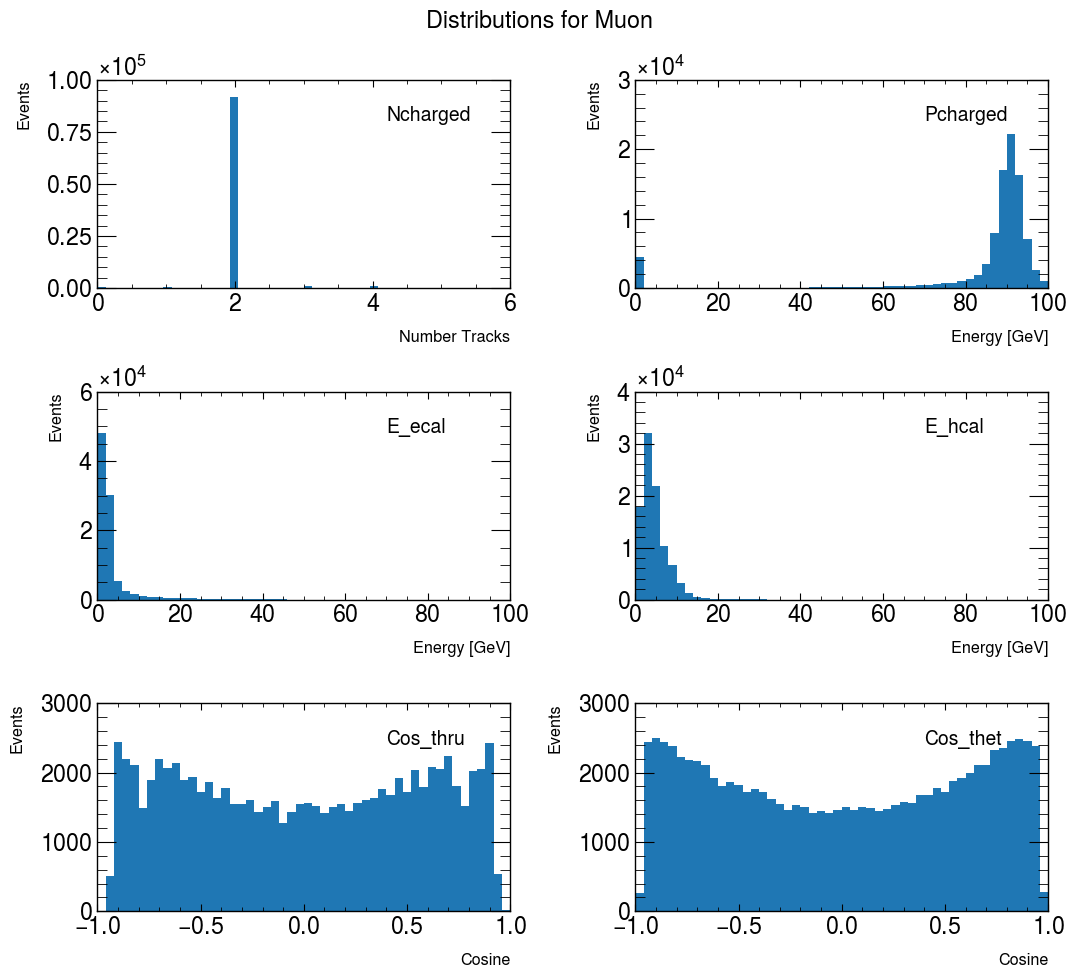

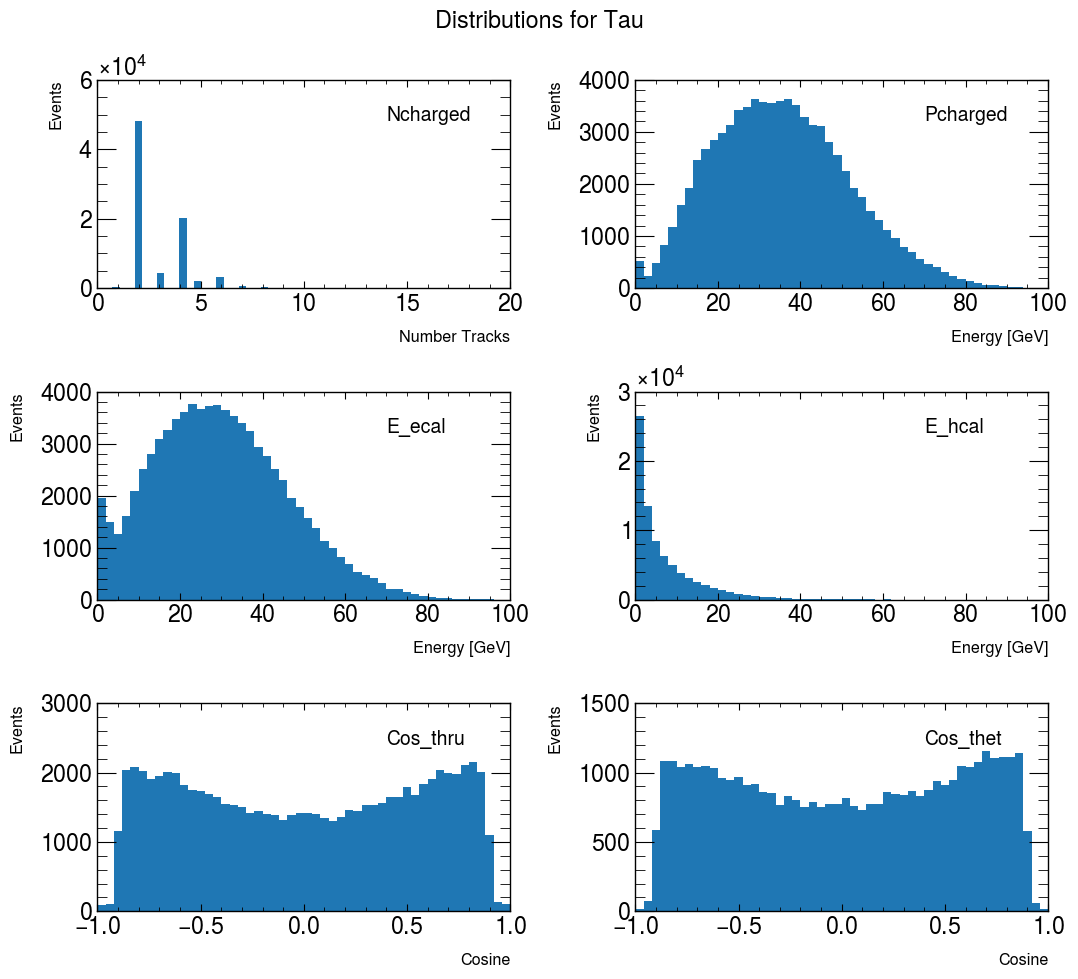

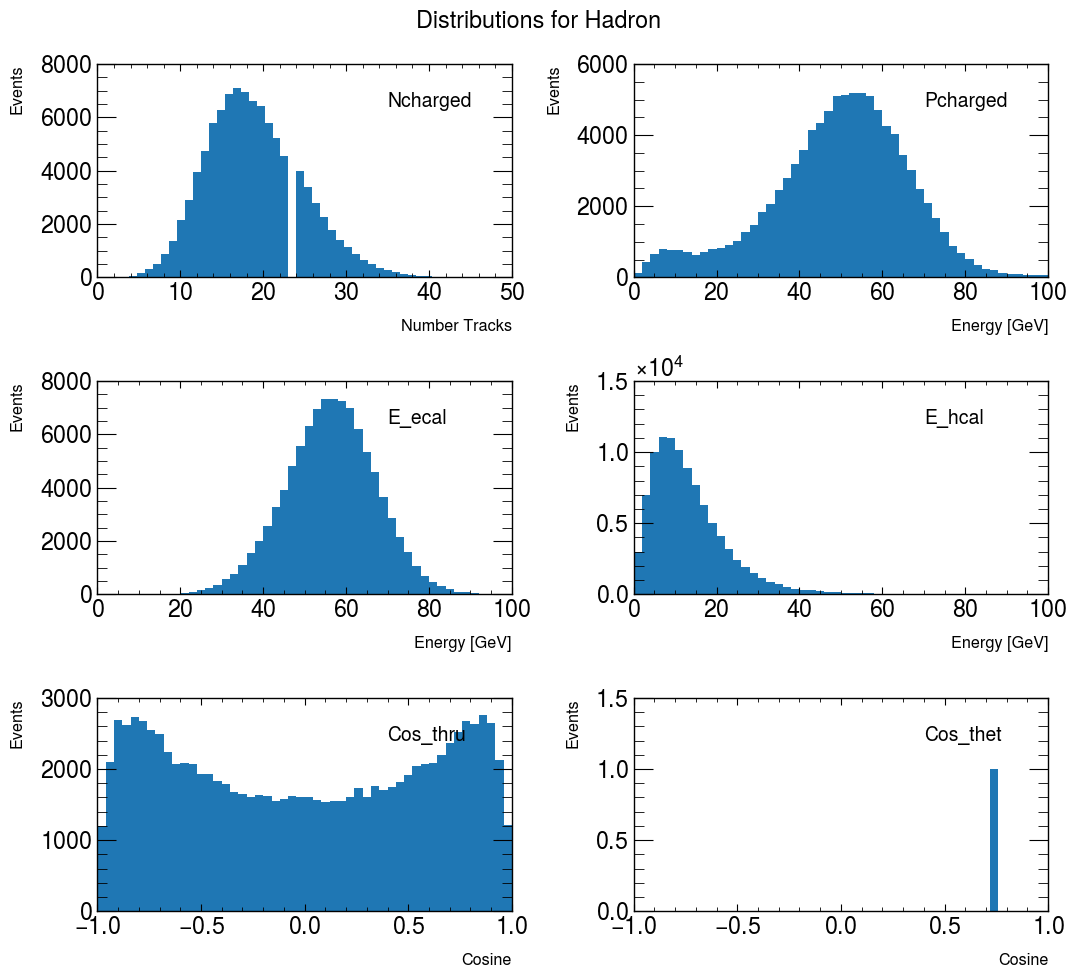

In [54]:
mc_dict = {"Electron":mc_ee,"Muon":mc_mm,"Tau":mc_tt,"Hadron":mc_qq}
for i in mc_dict.keys():
    fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(11,10))
    iax = 0
    jax = 0
    fig.suptitle("Distributions for "+i)
    for j in Nametable.keys():
        if not(Nametable[j] in [2,3,4,5,7,8]): continue
        if Nametable[j] in [3,4,5]: 
            rg = (0,100)
            xlab = "Energy [GeV]"
        if Nametable[j] == 2: 
            rg = (0,100)
            if max(mc_dict[i][:,Nametable[j]])<100: rg=(0,max(mc_dict[i][:,Nametable[j]]))
            xlab = "Number Tracks"
        if Nametable[j] in [7,8]: 
            rg = (-1,1)
            xlab = "Cosine"
        ax[iax][jax].hist(mc_dict[i][:,Nametable[j]],bins=50,range=rg)
        ax[iax][jax].text(0.7,0.8,j,transform=ax[iax][jax].transAxes)
        ax[iax][jax].set_xlabel(xlab,fontsize="small")
        ax[iax][jax].set_ylabel("Events",fontsize="small")
        jax+=1
        if jax>1:
            iax+=1
            jax=0
    plt.tight_layout()

### Statistical uncertainties to the histogram

Think about the statistical uncertainties computed above in 'error_sizes'. 
* **Are these sensible? Why do we use this formula?** (Hint: Making an histogram is, in short, a *counting experiment*. In the limit of large total number of events, the (binomial) probability function limits to the *Poisson distribution*. What is the variance? And the standard deviation?)

### *Example*: How to fit a distribution

In [24]:
#condition_ee, condition_mm, condition_tt, condition_hh
print(ML_Labels[condition_tt])   #0->ee ; 1->mm ; 2->tt ; 3->hh
print(mc_all[condition_tt][:,Nametable["E_ecal"]])
print(mc_all[ML_Labels==0][:,Nametable["E_ecal"]])
Nametable = {'Run':0, 'Event':1, 'Ncharged':2, 'Pcharged':3, 'E_ecal':4, 'E_hcal':5, 'E_lep':6, 'Cos_thru':7, 'Cos_thet':8 }

def Breit_Wigner(width):
    


[0 0 0 ... 3 3 3]
[70.42387  59.507435 74.9541   ... 66.56008  57.613796 51.52932 ]
[88.92962  90.303406 89.63274  ... 96.30155  92.580894 89.81569 ]


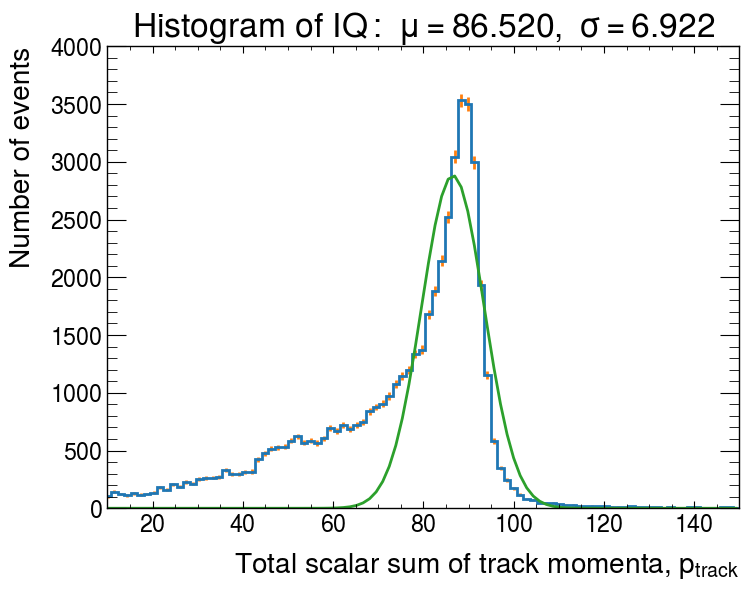

In [32]:
from scipy.optimize import curve_fit

mynewmask = mc_all[Nametable['Pcharged']] >= 31.23

# Plot data with statistical uncertainties
new_bin_content, new_bin_edges, _ = plt.hist(mc_all[condition_ee][:,Nametable["Pcharged"]],bins=100,range=(5.,150.),  histtype='step', linewidth=2, label='Pcharged')
new_mid = 0.5*(new_bin_edges[1:] + new_bin_edges[:-1]) #Calculate midpoint of the bars
new_error_sizes = np.sqrt(new_bin_content)

plt.errorbar(new_mid, new_bin_content, yerr=new_error_sizes, fmt='none')

### Show the plot on screen
plt.title('My title')
plt.xlim(10.,150.)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')


# Define model function to be used to fit to the data above:
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [321., 50., 32.]

## Fit curve (WARNING: The fit does not propagate bin uncertainties to the uncertainties of the fit parameters!)
coeff, var_matrix = curve_fit(gauss, new_mid, new_bin_content, p0=p0)

# Get the fitted curve
hist_fit = gauss(new_mid, *coeff)

plt.plot(new_mid, hist_fit, label='Fit')

plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=%.3f,\ \sigma=%.3f$' %(coeff[1], abs(coeff[2])))

plt.show()

### Matrix Inversion
To determine the uncertainties of the matrix elements after the inversion we use Monte Carlo toy experiments. In this context, what are the advantages and disadvantages of this method when compared to analytical expressions? Discuss it briefly.

**References**:
* Propagation of Errors for Matrix Inversion: https://arxiv.org/abs/hep-ex/9909031v1

Erros for the inverse matrix:
[[0.01723277 0.0001019  0.0001019  0.0001019 ]
 [0.0001019  0.01723277 0.0001019  0.0001019 ]
 [0.0001019  0.0001019  0.01723277 0.0001019 ]
 [0.0001019  0.0001019  0.0001019  0.01723277]]


(0.8, 1.1)

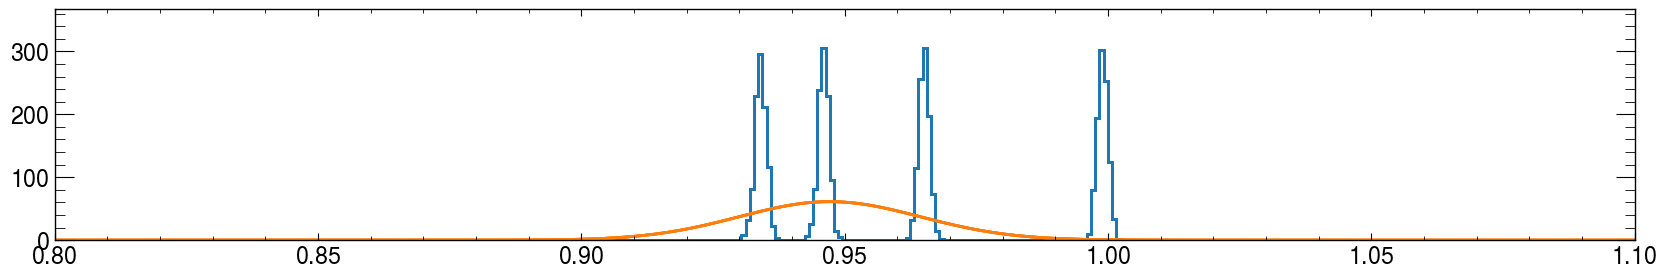

In [38]:
matrix = np.array([[0.934, 0.02,  0.01, 0.],
                  [0.01,  0.946, 0.01, 0.01],
                  [0.01,  0.01,  0.965,0.01],
                  [0.01,  0.01,  0.01, 0.999]])

error_matrix = np.array([[0.001,   0.0001,  0.0001, 0.0001],
                        [0.0001,  0.001,   0.0001, 0.0001],
                        [0.0001,  0.0001,  0.001,  0.0001],
                        [0.0001,  0.0001,  0.0001, 0.001]])

### Number of toy experiments to be done
ntoy = 1000

### Create numpy matrix of list to append elements of inverted toy matrices
inverse_toys = np.empty((4,4),dtype=object)
inverse_toys.fill([])

# Create toy efficiency matrix out of gaussian-distributed random values
for i in range(ntoy):
    toy_matrix = np.zeros((4,4))
    toy_matrix = np.random.normal(matrix,error_matrix,size=(4,4))

    ### Invert toy matrix
    inverse_toy = np.linalg.inv(toy_matrix)

    # Append values
    for j in range(4):
        for k in range(4):
            inverse_toys.item(j,k).append(toy_matrix.item(j,k))

# Define gaussian function to fit to the toy distributions:
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

inverse_errors = np.zeros((4,4))
inverse_means = np.zeros((4,4))

plt.figure(figsize=(20, 3))

# Fill histograms for each inverted matrix coefficient:
for j in range(4):
    for k in range(4):

        # Diagonal and off-diagonal terms have different histogram ranges
        rmin = 0. ; rmax = 0.
        if j==k:
            rmin = 0.8 ; rmax = 1.2
        else:
            rmin = -0.02 ; rmax = 0.02

        hbins, hedges, _ = plt.hist(inverse_toys.item(j,k),bins=500,range=(rmin,rmax),  histtype='step', linewidth=2, label=f'toyhist{j}{k}')
        plt.ylim(0.,1.2*max(hbins))


        # Get the fitted curve
        h_mid = 0.5*(hedges[1:] + hedges[:-1]) #Calculate midpoints for the fit
        coeffs, _ = curve_fit(gauss, h_mid, hbins)
        h_fit = gauss(h_mid, *coeffs)

        plt.plot(h_mid, h_fit,label=f'Fit{j}{k}')

        inverse_means[j,k] = coeffs[1]
        inverse_errors[j,k] = abs(coeffs[2])

print(f"Erros for the inverse matrix:\n{inverse_errors}")

# Exercise 2: Separate $t$- and $s$-channel contributions

Only Feynman diagrams contributing to the production of $Z$ boson are to be considered for the measurements. The **electron** Monte Carlo sample incorporate contributions from $t$- and $s$-channels.
* Select/correct contributions producing $Z$ boson decays. (Hint: Which role does the $\cos(\theta)$ distribution play in separating $t$- and $s$-channels?)

# Exercise 3: Measurement of the total production cross sections

For **each** of the seven centre-of-mass energies:
* Determine the number of events in the handronic channel *and* in the three leptonic channels
* Substract the background and correct for selection efficiencies accordingly
* Then, calculate the differnetial cross sections for the hadronic *and* the leptnic channels
* Add the radiation corrections from The table given below. **Don't forget to take the uncertainties (errors) into account!**

| $\sqrt{s}$   \[GeV\]| Correction hadronic channel    \[nb\] |  Correction leptonic channel   \[nb\]|
| --- | --- | --- |
| 88.47 | +2.0  | +0.09 |
| 89.46 | +4.3  | +0.20 |
| 90.22 | +7.7  | +0.36 |
| 91.22 | +10.8 | +0.52 |
| 91.97 | +4.7  | +0.22 |
| 92.96 | -0.2  | -0.01 |
| 93.76 | -1.6  | -0.08 |

Feel free to access these values using the dictionary 'xs_corrections' given below.
* Once the total cross section for all four decay channels at all seven energies have been measured, fit a **Breit-Wigner distribution** to measure the $Z$ boson mass ($m_Z$) and the resonance width ($\Gamma_Z$) and the peak cross section s of the resonance for the hadronic and the leptonic channels. Again, **propagate the uncertainties carefully**.
* Compare your results to the OPAL cross section s and the theoretical predictions. How many degrees of freedom does the fit have? How can you udge if the model is compatible with the measured data? Calculate the  **confidence levels**.
* Calculate the partial widths for all channels from the measured cross sections on the peak. Which is the best partial width to start with? Compare them with the theoretical predictions and the values that you have calculated in the beginning.
* Determine from your results the **number of generations of light neutrinos**. Which assumptions are necessary?
* Discuss in detail the systematic uncertainties in the whole procedure of the analysis. Which assumptions were necessary?

These are some **references** that might be interesting to look up:
* Particle Data Book: https://pdg.lbl.gov/2020/download/Prog.Theor.Exp.Phys.2020.083C01.pdf
** Resonances: https://pdg.lbl.gov/2017/reviews/rpp2017-rev-resonances.pdf
* Precision Electroweak Measurements on the Z Resonance (Combination LEP): https://arxiv.org/abs/hep-ex/0509008
* Measurement of the $Z^0$ mass and width with the OPAL detector at LEP: https://doi.org/10.1016/0370-2693(89)90705-3
* Measurement of the $Z^0$ line shape parameters and the electroweak couplings of charged leptons: https://inspirehep.net/literature/315269
* The OPAL Collaboration, *Precise Determination of the $Z$ Resonance Parameters at LEP: "Zedometry"*: https://arxiv.org/abs/hep-ex/0012018
* Fitting a Breit-Wigner curve using uproot: https://masonproffitt.github.io/uproot-tutorial/07-fitting/index.html

In [17]:
xs_corrections = { 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                      'hadronic' : [2.0, 4.3, 7.7, 10.8, 4.7, -0.2, -1.6],
                      'leptonic' : [0.09, 0.20, 0.36, 0.52, 0.22, -0.01, -0.08]}

# Exercise 3: Forward-backward asymmetry and $\sin^2(\theta_\text{W})$ in muon final states

* Using the **muon channel only**, measure the forward-backward asymmetry $\mathcal{A}_\text{FB}$ using OPAL data and muon Monte Carlo events. Take into account the radiation corrections given below. 

| $\sqrt{s}$   \[GeV\]| Radiation correction [-]|  
| --- | --- | 
| 88.47 | 0.021512  | 
| 89.46 | 0.019262  | 
| 90.22 | 0.016713  | 
| 91.22 | 0.018293  | 
| 91.97 | 0.030286  | 
| 92.96 | 0.062196  | 
| 93.76 | 0.093850  | 

Feel free to use the dictionary 'radiation_corrections' given below.

* Measure the **Weinberg angle** as $\sin^2(\theta_\text{W})$. Compare the measurement with the literature.

In [18]:
radiation_corrections = { 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                          'correction' : [0.021512, 0.019262, 0.016713, 0.018293, 0.030286, 0.062196, 0.093850]}

# Exercise 4: Tests on lepton universality¶

* Test the lepton universality from the total cross sectinos on the peak for $Z\to e^+ e^-$, $Z\to \mu^+ \mu^-$ and $Z\to \tau^+ \tau^-$ events. What is the ratio of the total cross section of the hadronic channel to the leptonic channels on the peak? Compare with the ratios obtained from the branching rations and discuss possible differences.